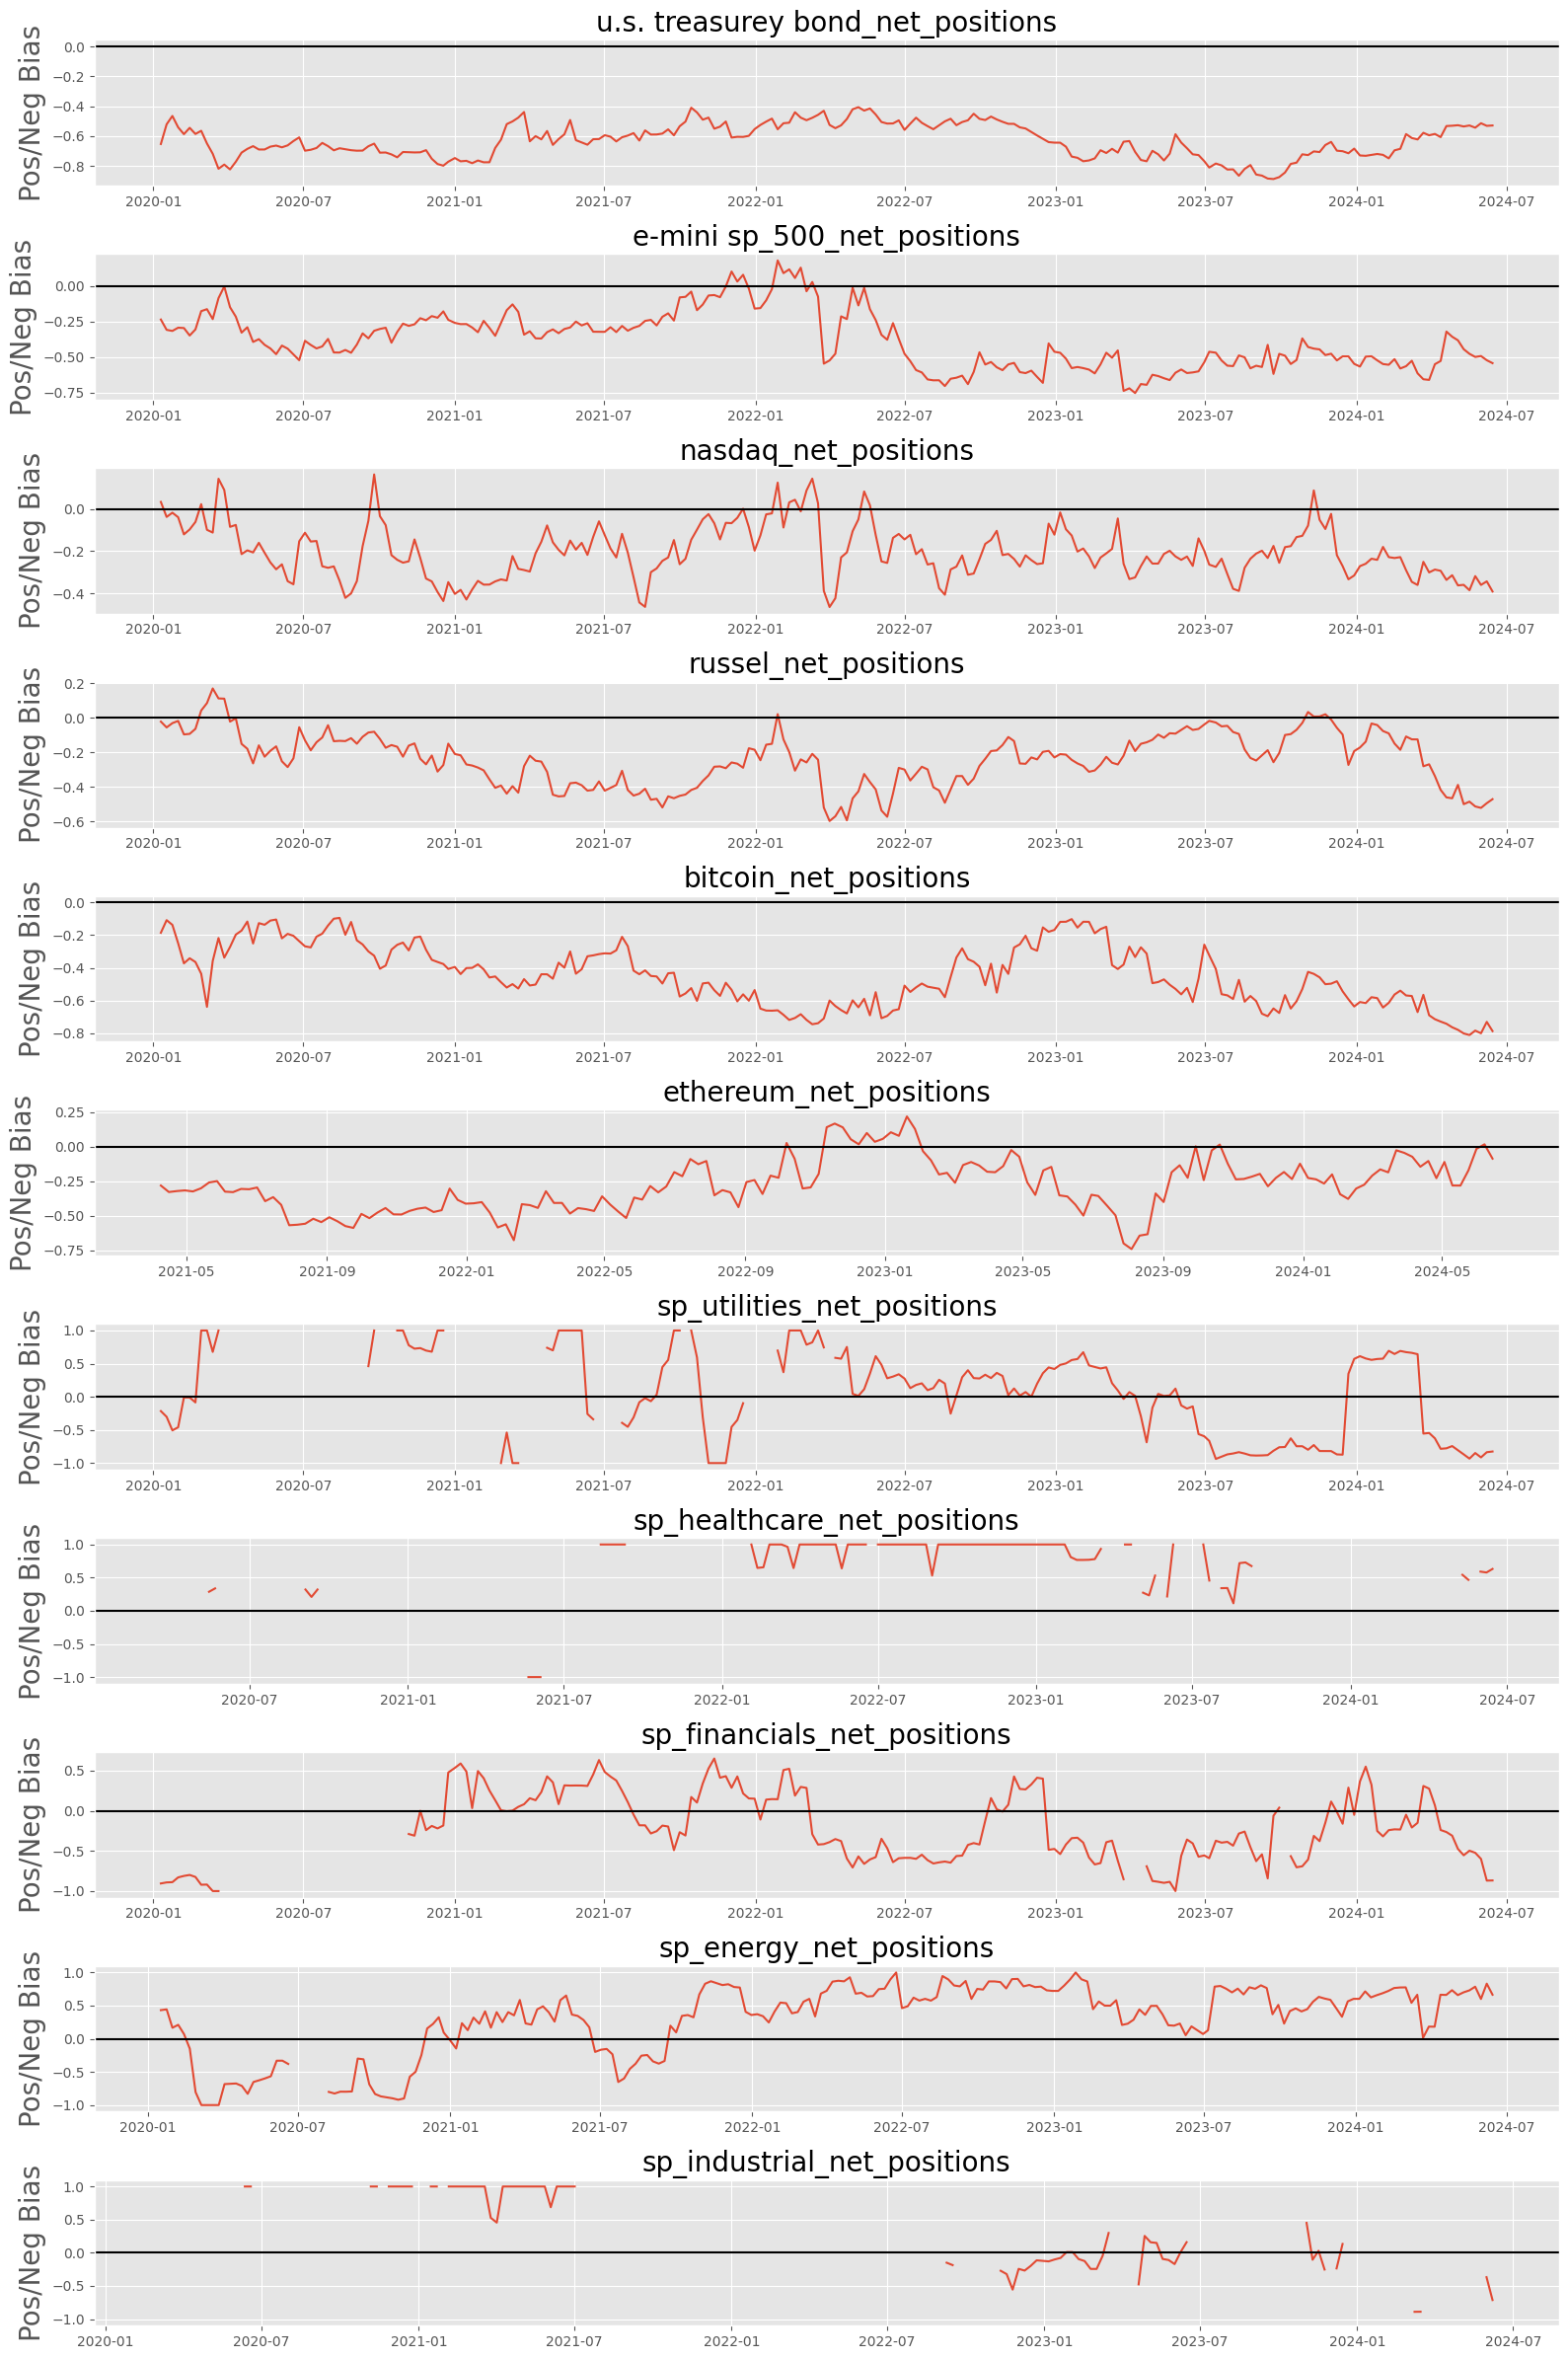

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import date, datetime
import pandas as pd
import requests
import zipfile
import io
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def get_COT_report(year):
    
    url = f'https://www.cftc.gov/files/dea/history/fut_fin_txt_{year}.zip'
    
    r = requests.get(url, stream=True)
    
    z = zipfile.ZipFile(io.BytesIO(r.content))
    
    z.extractall()
    
    for zipinfo in z.infolist():
        
        with z.open(zipinfo) as f:
            
            df = pd.read_csv(zipinfo.filename)
            
    df.set_index('Report_Date_as_YYYY-MM-DD', drop=True, inplace=True)
    
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    
    df.index.name = 'date'
    
    return df


def construct_COT_dataframe():
    
    this_year = date.today().year
    
    years = [this_year, this_year-1, this_year-2, this_year-3, this_year-4]
    
    df = pd.DataFrame()
    
    for i in years:
        
        temp_df = get_COT_report(i)
        
        df = pd.concat([df, temp_df], axis=0)
        
    return df.sort_index()


def get_financials_cot_df():
    
    contacts = {
        'u.s. treasurey bond':'020601',
                'e-mini sp_500':'13874A',
                'nasdaq':'209742',
                'russel':'239742',
                'bitcoin':'133741',
                'ethereum':'146021',
                'sp_utilities':'13874J',
                'sp_healthcare':'13874E',
                'sp_financials':'13874C',
                'sp_energy':'138749',
                'sp_industrial':'13874F'}

    cftc_df = construct_COT_dataframe()
    
    df = pd.DataFrame()
    
    for name, number in contacts.items():

        temp_df = cftc_df[cftc_df['CFTC_Contract_Market_Code']==number]

        temp_df = temp_df[['Market_and_Exchange_Names',
                           'Lev_Money_Positions_Long_All', 
                           'Lev_Money_Positions_Short_All',
                           'Open_Interest_All']]

        temp_df['net_positions'] = (temp_df['Lev_Money_Positions_Long_All']-temp_df['Lev_Money_Positions_Short_All'])/ \
                                    (abs(temp_df['Lev_Money_Positions_Long_All'])+abs(temp_df['Lev_Money_Positions_Short_All']))

        df = pd.concat([df, temp_df['net_positions'].to_frame(f'{name}_net_positions')], axis=1)
        
    df.index = df.index + pd.DateOffset(3)

    df.index.name = 'date'
    
    return df


def plot_all_graphs():

    df = get_financials_cot_df()

    fig, ax = plt.subplots(nrows=11, ncols=1, figsize=(16,24))

    for n, row in enumerate(ax):

            row.plot(df.iloc[:, n])

            row.set_title(f'{df.columns[n]}', fontsize=20)

            row.axhline(0, color='k')

            row.set_ylabel('Pos/Neg Bias', fontsize=20)

    fig.tight_layout()

    plt.show()
    

plot_all_graphs()

In [2]:
df = construct_COT_dataframe()
df.columns

Index(['Market_and_Exchange_Names', 'As_of_Date_In_Form_YYMMDD',
       'CFTC_Contract_Market_Code', 'CFTC_Market_Code', 'CFTC_Region_Code',
       'CFTC_Commodity_Code', 'Open_Interest_All', 'Dealer_Positions_Long_All',
       'Dealer_Positions_Short_All', 'Dealer_Positions_Spread_All',
       'Asset_Mgr_Positions_Long_All', 'Asset_Mgr_Positions_Short_All',
       'Asset_Mgr_Positions_Spread_All', 'Lev_Money_Positions_Long_All',
       'Lev_Money_Positions_Short_All', 'Lev_Money_Positions_Spread_All',
       'Other_Rept_Positions_Long_All', 'Other_Rept_Positions_Short_All',
       'Other_Rept_Positions_Spread_All', 'Tot_Rept_Positions_Long_All',
       'Tot_Rept_Positions_Short_All', 'NonRept_Positions_Long_All',
       'NonRept_Positions_Short_All', 'Change_in_Open_Interest_All',
       'Change_in_Dealer_Long_All', 'Change_in_Dealer_Short_All',
       'Change_in_Dealer_Spread_All', 'Change_in_Asset_Mgr_Long_All',
       'Change_in_Asset_Mgr_Short_All', 'Change_in_Asset_Mgr_Spread_All